<a href="https://colab.research.google.com/github/Motunrayo244/greatExpectationLLM/blob/main/finetuning/GE_Llama_3_2_1B%2B3B_Conversational_%2B_2x_faster_finetuning_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
#!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git
!pip install optuna
!pip install optuna-dashboard
!pip install datasets
!optuna-dashboard sqlite:///db.sqlite3
!pip install unsloth vllm
!pip install --upgrade pillow

!pip install git+https://github.com/huggingface/trl.git@e95f9fb74a3c3647b86f251b7e230ec51c64b72b


In [ ]:
# Access files using GitHub API
import requests
import os
import pandas as pd
import requests
import os
import torch
import textwrap
import csv
import time
import json
import optuna
import shutil
import re

from datasets import load_dataset
from datetime import datetime
from sklearn.model_selection import train_test_split
from unsloth import FastLanguageModel, to_sharegpt, is_bfloat16_supported
from unsloth.chat_templates import get_chat_template, train_on_responses_only
from trl import SFTTrainer,SFTConfig
from transformers import TrainingArguments, DataCollatorForSeq2Seq, EarlyStoppingCallback
from unsloth.chat_templates import standardize_sharegpt
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

Unsloth: Patching Xformers to fix some performance issues.
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


# GELM - Great Expectation Language Model

This Notebook is an adaptation of unsloth tutorial for finetuning LLAMA-3.2. Follow instructions in https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing to view original notebook. View other tutorials in https://docs.unsloth.ai/get-started/unsloth-notebooks.

## Function Definition




In [5]:
# Function to download files and handle subfolders recursively
def download_folder(url, local_path):
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        os.makedirs(local_path, exist_ok=True)
        for item in response.json():
            item_name = item['name']
            item_path = os.path.join(local_path, item_name)
            if item['type'] == 'file':
                print(f"Downloading file: {item_name}")
                with open(item_path, 'wb') as f:
                    file_response = requests.get(item['download_url'], headers=headers)
                    f.write(file_response.content)
            elif item['type'] == 'dir':
                print(f"Entering subfolder: {item_name}")
                download_folder(item['url'], item_path)
    else:
        print(f"Failed to access {url}: {response.status_code}, {response.text}")

In [6]:
def combine_csv_files(input_folder, output_file):
    """
    Combines all CSV files in a folder (including subfolders) into one CSV file.

    Parameters:
    - input_folder (str): Path to the folder containing CSV files.
    - output_file (str): Path to save the combined CSV file.
    """
    all_data = []  # List to store dataframes

    # Walk through all files and subfolders
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                print(f"Reading {file_path}")
                try:
                    df = pd.read_csv(file_path)
                    df['source_file'] = file  # Add a column to track the source file
                    all_data.append(df)
                except Exception as e:
                    print(f"Failed to read {file_path}: {e}")
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df.to_csv('data/combined_dataset.csv', index=False)
        print(f"Combined CSV saved as {output_file}")
    else:
        print("No CSV files found in the specified folder.")


In [7]:
def get_accepted_expectations():
    """
    Reads the list of accepted expectations from an csv and returns a dictionary.
    """
    try:
        expectation_list = pd.read_csv('data/finetuning_dataset/listExpectations.csv', usecols=['Category', 'Expectations'])
        expectation_list['Category'] = expectation_list['Category'].ffill()  # Forward fill NaN values in 'Category'
        expectation_category_dict = (
            expectation_list.groupby('Category')['Expectations']
            .apply(list)
            .to_dict()
        )
        print("Accepted expectations successfully loaded.")
        return expectation_category_dict
    except Exception as e:
        print(f"Error loading accepted expectations: {e}")
        raise

In [8]:
def formatting_prompts_func(examples, tokenizer):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }


def convert_data_to_sharegpt(dataset_file):

  dataset = load_dataset("json", data_files = dataset_file, split = "train")
  dataset = to_sharegpt(dataset,
                      merged_prompt= "{instruction} [[\n User prompt is: \n{user_prompt}]]"
                      ,output_column_name="generated_expectations"
                      )
  return dataset
def to_standardize_sharegpt(dataset,tokenizer):
  dataset = standardize_sharegpt(dataset)
  dataset = dataset.map(lambda examples: formatting_prompts_func(examples, tokenizer), batched=True)
  return dataset

In [9]:

def shuffle_and_split(df, test_size=0.1, random_state=42):
    # Assuming the last column is the label column, you can adjust this if needed
    X = df.iloc[:, :-1]  # All columns except the last one
    y = df.iloc[:, -1]   # The last column is assumed to be the label

    # Shuffle and split the DataFrame into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)

    return train_df, test_df


In [10]:
def initialize_model_tokinizer(model_name='unsloth/Llama-3.2-3B-bnb-4bit', max_seq_length=512, dtype=None, load_in_4bit=True):

#max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
#dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
#load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name = model_name,                #"unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
      max_seq_length = max_seq_length,
      dtype = dtype,
      load_in_4bit = load_in_4bit,
      # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
  )
  return model, tokenizer

In [11]:
def define_model(
    model, r=64, target_modules=None, lora_alpha=16, lora_dropout=0, bias="none",use_gradient_checkpointing="unsloth", random_state=20, use_rslora=False, loftq_config=None,
    adapter_name=None, gradient_checkpointing_ratio=0.5, device_map="auto", torch_dtype="auto", use_flash_attention=True, compile_model=False):
    """
    Dynamically define a PEFT model with LoRA configuration.

    Args:
        model: Pretrained base model to wrap with PEFT.
        r (int): LoRA rank, higher values improve expressiveness (8, 16, 32, 64, 128).
        target_modules (list): Modules to apply LoRA (e.g., "q_proj", "k_proj").
        lora_alpha (int): Scaling factor for LoRA layers.
        lora_dropout (float): Dropout rate for LoRA layers.
        bias (str): Bias type ("none", "all", "lora_only").
        use_gradient_checkpointing (bool/str): Gradient checkpointing for memory efficiency.
        random_state (int): Random seed for reproducibility.
        use_rslora (bool): Whether to use Rank-Stabilized LoRA.
        loftq_config (dict/None): LoftQ configuration dictionary if needed.
        adapter_name (str/None): Name of the adapter configuration.
        gradient_checkpointing_ratio (float): Percentage of layers using checkpointing.
        device_map (str): Device mapping for multi-GPU or single GPU setup.
        torch_dtype (str): Data type for tensors ("float16", "bfloat16", "auto").
        use_flash_attention (bool): Enable flash attention for memory optimization.
        compile_model (bool): Whether to compile the model for speed optimization.

    Returns:
        model: The configured PEFT model with LoRA applied.
    """
    if target_modules is None:
        target_modules = [
            "q_proj", "k_proj", "v_proj", "o_proj",
            "gate_proj", "up_proj", "down_proj"
        ]

    model = FastLanguageModel.get_peft_model(
        model,
        r=r,
        target_modules=target_modules,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        bias=bias,
        use_gradient_checkpointing=use_gradient_checkpointing,
        random_state=random_state,
        use_rslora=use_rslora,
        loftq_config=loftq_config,
    )

    # Apply additional configurations
    if adapter_name:
        model.set_adapter(adapter_name)

    #if use_flash_attention:
        #model.enable_flash_attention()

    if gradient_checkpointing_ratio is not None:
        model.gradient_checkpointing_ratio = gradient_checkpointing_ratio

    if compile_model:
        model = torch.compile(model)

    return model


In [12]:

def train_model(
    model,
    tokenizer,
    train_dataset,
    eval_dataset,
    dataset_text_field="text",
    max_seq_length=512,
    dataset_num_proc=2,
    packing=True,
    learning_rate=1e-4,
    optimizer="adamw_8bit",
    gradient_accumulation_steps=2,
    num_train_epochs=3,  # ⬅ Increased epochs from steps to 3 full epochs
    per_device_train_batch_size=2,
    warmup_steps=5,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="epoch",  # ⬅ Evaluate at the end of each epoch
    output_dir="outputs",
    seed=20,
):

    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        warmup_steps=warmup_steps,
        num_train_epochs=num_train_epochs,  # ⬅ Use epochs instead of steps
        learning_rate=learning_rate,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        weight_decay=weight_decay,
        logging_steps=logging_steps,
        evaluation_strategy=eval_strategy,
        save_strategy="epoch",  # ⬅ Save at the end of each epoch
        save_total_limit=2,  # ⬅ Limit saved checkpoints
        load_best_model_at_end=True,  # ⬅ Load best validation loss model
        metric_for_best_model="loss",  # ⬅ Use validation loss to decide best model
        greater_is_better=False,  # ⬅ Lower loss is better
        optim=optimizer,
        seed=seed,
        report_to="none",
    )

    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        dataset_text_field=dataset_text_field,
        max_seq_length=max_seq_length,
        data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # ⬅ Stops if no improvement for 2 epochs
        dataset_num_proc=dataset_num_proc,
        packing=packing,
        args=training_args,
    )

    return trainer


In [13]:
#stepwise one epoch

def train_model(
    model,
    tokenizer,
    train_dataset,
    eval_dataset,
    dataset_text_field = "text",
    max_seq_length = 512,
    dataset_num_proc = 2,
    packing = True,
    learning_rate=1e-4,
    num_train_epochs=3,
    optimizer="adamw_8bit",
    gradient_accumulation_steps=2,
    max_steps=50,
    per_device_train_batch_size=2,
    warmup_steps=5,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="epoch",
    output_dir="outputs",
    seed=20,
):

    """
    Dynamically configure and return an SFTTrainer instance with essential parameters.

    Args:
        model: The model to train.
        tokenizer: The tokenizer for the model.
        train_dataset: Dataset for training.
        eval_dataset: Dataset for evaluation.
        learning_rate: Learning rate for training.
        optimizer: Optimizer to use (e.g., "adamw_8bit").
        gradient_accumulation_steps: Number of gradient accumulation steps.
        max_steps: Maximum number of training steps.
        per_device_train_batch_size: Batch size per device during training.
        warmup_steps: Number of warmup steps.
        weight_decay: Weight decay for regularization.
        logging_steps: Frequency of logging steps.
        evaluation_strategy: Evaluation strategy ("steps" or "epoch").
        save_steps: Frequency of saving checkpoints.
        output_dir: Directory to save outputs.
        seed: Random seed for reproducibility.

    Returns:
        SFTTrainer: Configured trainer object.
    """
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        warmup_steps=warmup_steps,
        max_steps=max_steps,
        learning_rate=learning_rate,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        weight_decay=weight_decay,
        logging_steps=logging_steps,
        eval_strategy=eval_strategy,
        save_steps=int(max_steps/2),
        load_best_model_at_end=True,
        optim=optimizer,
        seed=seed,
        report_to="none",  # Change this to "wandb" or "tensorboard" if needed
    )

    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        dataset_text_field="text",
        max_seq_length=max_seq_length,
        data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        dataset_num_proc=2,
        packing=False, # Can make training 5x faster for short sequences.
        args=training_args,
    )
    return trainer


In [14]:
def start_training( model, tokenizer, train_dataset, eval_dataset, max_seq_length, learning_rate=1e-4,
                   optimizer="adamw_8bit", max_steps=50,random_state=20, lora_alpha=16,bias = "none" ):
  model = define_model(model=model, lora_alpha=lora_alpha, bias=bias, use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = random_state,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    )

  trainer = train_model(
    model = model,
    tokenizer = tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    max_seq_length=max_seq_length,
    learning_rate=learning_rate,
    optimizer=optimizer,
    #max_steps=max_steps,
    )

  trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
    )

  print("Training...")
  trainer_stats = trainer.train()

  return trainer, model, tokenizer



## Load Data and Prepare Dataset


### Prepare Dataset

In [ ]:
aug_dataset = pd.read_csv('../data/finetuning_dataset\combined_processed_dataset.csv',usecols=['user_prompt', 'generated_expectations'])
initial_dataset = pd.read_csv('../data/finetuning_dataset\dataset _from_Industry_data_contract.csv',usecols=['user_prompt', 'generated_expectations'])

dataset = pd.concat([aug_dataset, initial_dataset], ignore_index=True)
expectation_list = pd.read_excel('data/expectation_and_prompt_sample/listExpectations.xlsx')

In [ ]:
dataset.shape

<a name="Data"></a>
### Data Prep
using the `Llama-3.1` format for conversation style finetunes. The dataset needs to be converted into  ShareGPT style. then to the  HuggingFace's normal multiturn format `("role", "content")` instead of `("from", "value")`

⛓ Llama-3 renders multi turn conversations like below:
```
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Hello!<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Hey there! How are you?<|eot_id|><|start_header_id|>user<|end_header_id|>

I'm great thanks!<|eot_id|>
```
I used the `get_chat_template` function to get the correct chat template.

Unsloth supports `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, phi3, llama3` and more.

For this experiment, I will use the generated dataset it into train and test set. Then store them as json files. Following this we load the train set and convert it to the acceptable format using a two step process.

1.   Convert to chat template format
2.   Convert to sharegpt format as directed in the tutorial notebook.



In [ ]:
data_df = dataset.copy()
# remove all unwanted space and indentations from the expectations
data_df['generated_expectations'] = data_df['generated_expectations'].apply(lambda x: x.replace('      ', '').replace('\n',',').replace(',,',','))

In [ ]:
# Fetch the accepted expectations dictionary
accepted_expectations = get_accepted_expectations()

# Convert the accepted expectations dictionary to a string representation
expectations_reference = "\n".join(
    [f"{category}: {', '.join(expectations)}" for category, expectations in accepted_expectations.items()]
)

In [ ]:
data_df['instruction'] = textwrap.dedent(f'''Convert the data quality prompts to great_expectations in the form expectation_type(columnName, params...)
                                              Generate all expectations within 512 tokens Review expectations to remove duplicates.
                                              Do not hallucinate ''').strip()

In [ ]:
data_df.shape

In [ ]:
def create_datasets(dataset, test_size, eval_size):
  train_df, test_df = shuffle_and_split(dataset, test_size=test_size)
  train_df, eval_df = shuffle_and_split(train_df, test_size =eval_size)
  train_df.to_json("data/train.jsonl", orient='records', lines=True)
  eval_df.to_json("data/eval.jsonl", orient='records', lines=True)
  test_df.to_json("data/test.jsonl", orient='records', lines=True)


In [ ]:
test_size = 0.1
eval_size = 0.1

create_datasets(data_df, test_size, eval_size)

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

## Train

We look at how the conversations are structured for item 5:

fourbit_models = [ "unsloth/Meta-Llama-3.1-8B-bnb-4bit", # Llama-3.1 2x faster "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit", "unsloth/Meta-Llama-3.1-70B-bnb-4bit", "unsloth/Meta-Llama-3.1-405B-bnb-4bit", # 4bit for 405b! "unsloth/Mistral-Small-Instruct-2409", # Mistral 22b 2x faster! "unsloth/mistral-7b-instruct-v0.3-bnb-4bit", "unsloth/Phi-3.5-mini-instruct", # Phi-3.5 2x faster! "unsloth/Phi-3-medium-4k-instruct", "unsloth/gemma-2-9b-bnb-4bit", "unsloth/gemma-2-27b-bnb-4bit", # Gemma 2x faster! "unsloth/Llama-3.2-1B-bnb-4bit", # NEW! Llama 3.2 models "unsloth/Llama-3.2-1B-Instruct-bnb-4bit", "unsloth/Llama-3.2-3B-bnb-4bit", "unsloth/Llama-3.2-3B-Instruct-bnb-4bit", ] # More models at https://huggingface.co/unsloth

In [ ]:
def objective(trial):
    learning_rate =  2e-4 #trial.suggest_float('learning_rate', 1e-4, 4e-4,log=True)
    lora_alpha = 32 #trial.suggest_int('lora_alpha', 16, 32, step=16)
    optimizer =  trial.suggest_categorical('optimizer', ["adamw_8bit", "adamw_torch"])
    max_steps =   200 #trial.suggest_int('max_steps', 100, 200, step=50)
    max_seq_length = 512 #trial.suggest_int('max_seq_length', 512, 512, step=256)
    model_name = 'unsloth/Llama-3.2-3B-bnb-4bit'  #trial.suggest_categorical('model_name', ['unsloth/Llama-3.2-3B-bnb-4bit', 'unsloth/Llama-3.2-1B-bnb-4bit',])
    load_in_4bit = True #trial.suggest_categorical('load_in_4bit', [True, False])
    epoch=trial.suggest_int('epoch', 2, 3, step=1)


    model, tokenizer = initialize_model_tokinizer(model_name=model_name, max_seq_length=max_seq_length,
                                                  load_in_4bit=load_in_4bit,)
    tokenizer = get_chat_template(tokenizer, chat_template="llama-3.1")

    train_dataset = to_standardize_sharegpt(convert_data_to_sharegpt("data/train.jsonl"),tokenizer=tokenizer)
    eval_dataset = to_standardize_sharegpt(convert_data_to_sharegpt("data/eval.jsonl"), tokenizer=tokenizer)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Eval dataset size: {len(eval_dataset)}")


    trainer, model, tokenizer = start_training(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        max_seq_length=max_seq_length,
        learning_rate=learning_rate,
        optimizer=optimizer,
        max_steps=max_steps,
        lora_alpha=lora_alpha,
        random_state=20,
        bias="none"
    )

    metrics = trainer.evaluate()
    eval_loss = metrics['eval_loss']

    # Log trial details
    today = datetime.now().strftime("%Y_%m_%d")

    with open(f"training_history_{today}.csv", "a", newline='') as f:
        writer = csv.writer(f)
        writer.writerow([trial.number, model_name, learning_rate, lora_alpha, optimizer, max_steps,max_seq_length, eval_loss])

    return eval_loss

In [ ]:
study = optuna.create_study(direction='minimize')  # Minimize eval_loss
study.optimize(objective, n_trials=2)

# Print best parameters
print("Best trial:")
print(study.best_trial.params)


In [ ]:

best_params = study.best_trial.params

In [ ]:
best_model, best_tokenizer = initialize_model_tokinizer(
    model_name=best_params['model_name'],
    max_seq_length=best_params['max_seq_length'],
    load_in_4bit=True
)

best_tokenizer = get_chat_template(best_tokenizer, chat_template="llama-3.1")
train_dataset = to_standardize_sharegpt(convert_data_to_sharegpt("data/train.jsonl"),tokenizer=best_tokenizer)
eval_dataset = to_standardize_sharegpt(convert_data_to_sharegpt("data/eval.jsonl"), tokenizer=best_tokenizer)



# Re-train with Best Parameters
trainer, best_model, best_tokenizer = start_training(
    model=best_model,
    tokenizer=best_tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    max_seq_length=best_params['max_seq_length'],
    learning_rate=best_params['learning_rate'],
    optimizer=best_params['optimizer'],
    #max_steps=best_params['max_steps'],
    lora_alpha=best_params['lora_alpha'],
    random_state=20,
    bias="none"
)

==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2972 [00:00<?, ? examples/s]

Map:   0%|          | 0/326 [00:00<?, ? examples/s]

Training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,972 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 2
\        /    Total batch size = 4 | Total steps = 2,229
 "-____-"     Number of trainable parameters = 97,255,424


Epoch,Training Loss,Validation Loss
1,0.405800,0.422651
2,0.415300,0.415243
3,0.400500,0.417905


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


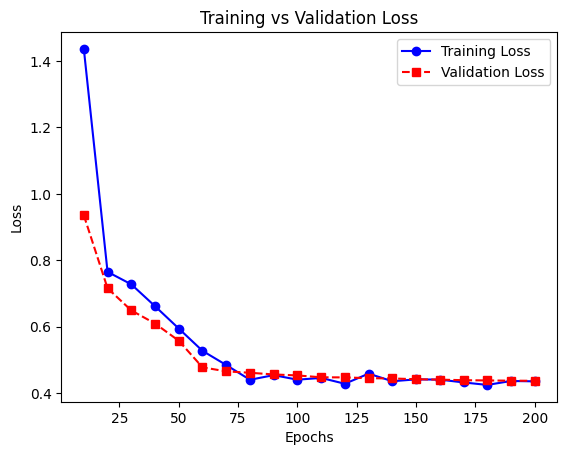

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt

training_loss = trainer.state.log_history['loss']
validation_loss = trainer.state.log_history['eval_loss']  
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, marker='o', linestyle='-', label="Training Loss", color="blue")
plt.plot(epochs, validation_loss, marker='s', linestyle='--', label="Validation Loss", color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [ ]:
# Save Best Model
today = datetime.now().strftime("%Y_%m_%d")
best_model.save_pretrained(f"best_model_{today}")
best_tokenizer.save_pretrained(f"best_model_{today}")

print(f"\n✅ Best model saved to 'best_model_{today}'")


✅ Best model saved to 'best_model_2025_02_10'


In [ ]:
import shutil

# Zip the model folder
shutil.make_archive(f'best_model_{today}', 'zip', f'best_model_{today}')


'/content/best_model_2025_02_09.zip'

In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

2327.4861 seconds used for training.
38.79 minutes used for training.
Peak reserved memory = 6.158 GB.
Peak reserved memory for training = 2.883 GB.
Peak reserved memory % of max memory = 41.755 %.
Peak reserved memory for training % of max memory = 19.548 %.


## Inference.

This section uses the model to get GE output from prompts in the test dataset.

#### IMPORT Model from Local storage

In [ ]:
#unzip the model
zipped_model_file = '{best_model_}'# Path to the zipped model file

# Directory to extract the files
extract_dir = "model"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file using shutil
shutil.unpack_archive(zipped_model_file, extract_dir)


In [ ]:
model_dir='model_directory'
model,tokenizer = FastLanguageModel.from_pretrained(model_dir,
                                          max_seq_length = 512,
                                          dtype = None,
                                          load_in_4bit = True,
                                             ).to("cuda")

In [ ]:
'''
model = AutoModelForCausalLM.from_pretrained(model_dir,
                                                 torch_dtype=torch.float16,  # Use float16 precision
                                             ).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Ensure faster inference (if supported by your framework)
FastLanguageModel.for_inference(model)
'''

'\nmodel = AutoModelForCausalLM.from_pretrained(model_dir,\n                                                 torch_dtype=torch.float16,  # Use float16 precision\n                                             ).to("cuda")\ntokenizer = AutoTokenizer.from_pretrained(model_dir)\n\n# Ensure faster inference (if supported by your framework)\nFastLanguageModel.for_inference(model)\n'

#### Import Model from Hugging Face

#### Evaluate with test dataset

In [ ]:

model = best_model
tokenizer = best_tokenizer

In [ ]:
#load test file
test_file_path = "../data/test.jsonl"

# read the test dataset
with open(test_file_path, "r") as file:
    test_data = [json.loads(line) for line in file]


In [19]:
# Ensure faster inference (if supported by your framework)
FastLanguageModel.for_inference(model)



LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): 

In [20]:
results = []

# Iterate through each test example
for data in tqdm(test_data):
    user_prompt = data["user_prompt"]

    # Prepare the input message
    messages = [{"role": "user", "content": user_prompt}]

    # Tokenize the input
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Required for generation
        return_tensors="pt",
    ).to("cuda")

    # Generate output
    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=256,
        use_cache=True,
        temperature=1.5,
        min_p=0.1
    )

    # Decode the output
    generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Append results
    results.append({
        "user_prompt": user_prompt,
        "generated_expectations": generated_text.strip()
    })


100%|██████████| 1420/1420 [3:43:06<00:00,  9.43s/it]


In [21]:
# Post-process to clean generated_expectations
for result in results:
    raw_text = result['generated_expectations']

    # Extract content after 'assistant\n\n' and before the '?>' if it exists
    cleaned_text = re.search(r"assistant\n\n(.*?)(\?>|$)", raw_text, re.DOTALL)
    if cleaned_text:
        result['great_expectations'] = cleaned_text.group(1).strip()



In [22]:
results[0]

{'user_prompt': "Check that the `threat_level` column has values that are either 'Low', 'Medium', or 'High', ensuring uniqueness.",
 'generated_expectations': "system\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\nuser\n\nCheck that the `threat_level` column has values that are either 'Low', 'Medium', or 'High', ensuring uniqueness.assistant\n\nThe `last_modified` column has been populated with current date, with no null values.\n\n`#pragma`\n```\nINSERT INTO `KnowledgeDate`.`圭圭naire`.`圭圭naire` VALUES ('a', '2023', '23 July', '2023', '12 July 23:15', '12 July 2023', '1');\n```\n```sql\nINSERT INTO `圭圭naire`.`圭圭naire` VALUES ('b', '2023', '23 July', '2023', '12 July 23:15', '12 July 2023', '1');\n```\n```sql\nINSERT INTO `圭圭naire`.`圭圭naire` VALUES ('c', '2023', '23 July', '2023', '12 July 23:15', '12 July 2023', '1');\n```",
 'great_expectations': "The `last_modified` column has been populated with current date, with no null values.\n\n`#pragma`\n```\nINSERT INTO 

In [ ]:
output_file_path = "../data/inference_results.jsonl"

with open(output_file_path, "w") as file:
    for result in results:
        file.write(json.dumps(result) + "\n")

print(f"Inference completed and saved to {output_file_path}")


Inference completed and saved to data/base_inference_results.jsonl


## Evaluation

This section uses ROUGE and BLEU score to Evaluate the inference from the model and compare it to the ground thruth.

In [24]:
%%capture
!pip install rouge-score sacrebleu
!pip install evaluate nltk


In [25]:
from rouge_score import rouge_scorer
from evaluate import load

import sacrebleu
import json
import pandas as pd
import os

In [ ]:
# Paths to test and inference files
test_file_path = "../data/test.jsonl"
inference_file_path = "../data/base_inference_results.jsonl"
output_csv_path = "../data/eval_results_dataset.csv"

# Ensure the data directory exists
os.makedirs("../data", exist_ok=True)

# Load test and inference data
def load_jsonl(file_path):
    with open(file_path, "r") as file:
        return [json.loads(line) for line in file]

test_data = load_jsonl(test_file_path)
inference_data = load_jsonl(inference_file_path)


In [27]:
inference_data[0]

{'user_prompt': "Check that the `threat_level` column has values that are either 'Low', 'Medium', or 'High', ensuring uniqueness.",
 'generated_expectations': "system\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\nuser\n\nCheck that the `threat_level` column has values that are either 'Low', 'Medium', or 'High', ensuring uniqueness.assistant\n\nThe `last_modified` column has been populated with current date, with no null values.\n\n`#pragma`\n```\nINSERT INTO `KnowledgeDate`.`圭圭naire`.`圭圭naire` VALUES ('a', '2023', '23 July', '2023', '12 July 23:15', '12 July 2023', '1');\n```\n```sql\nINSERT INTO `圭圭naire`.`圭圭naire` VALUES ('b', '2023', '23 July', '2023', '12 July 23:15', '12 July 2023', '1');\n```\n```sql\nINSERT INTO `圭圭naire`.`圭圭naire` VALUES ('c', '2023', '23 July', '2023', '12 July 23:15', '12 July 2023', '1');\n```",
 'great_expectations': "The `last_modified` column has been populated with current date, with no null values.\n\n`#pragma`\n```\nINSERT INTO 

In [ ]:
# Initialize scorers
rouge = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# Collect results
results = []

for test, inference in zip(test_data, inference_data):
    # Get the ground-truth and generated expectations
    reference = test["generated_expectations"]
    hypothesis = inference["great_expectations"]

    # Compute ROUGE scores


    # Compute ROUGE scores
    rouge_scores = rouge.score(reference, hypothesis)

    # Compute granular BLEU score
    gran_bleu_score = sacrebleu.sentence_bleu(hypothesis, [reference])

    # Append result
    results.append({
        "user_prompt": test["user_prompt"],
        "reference": reference,
        "hypothesis": hypothesis,
        "rouge1_fmeasure": rouge_scores["rouge1"].fmeasure,
        "rouge2_fmeasure": rouge_scores["rouge2"].fmeasure,
        "rougeL_fmeasure": rouge_scores["rougeL"].fmeasure,
        "granular_bleu_score": gran_bleu_score.score
    })


In [ ]:
results[0]

{'user_prompt': "Check that the `threat_level` column has values that are either 'Low', 'Medium', or 'High', ensuring uniqueness.",
 'reference': 'expect_column_values_to_be_in_set(column="threat_level", value_set=["Low", "Medium", "High"]),expect_column_values_to_be_unique(column="threat_level")',
 'hypothesis': 'expect_column_values_to_be_in_set(column="threat_level", value_set=[\'Low\', \'Medium\', \'High\']),expect_column_values_to_be_unique(column="threat_level")',
 'rouge1_fmeasure': 1.0,
 'rouge2_fmeasure': 1.0,
 'rougeL_fmeasure': 1.0,
 'granular_bleu_score': 79.47440347019332}

In [ ]:
predictions = [r['hypothesis'] for r in results]
references=[r['reference'] for r in results]

In [ ]:
len(predictions)

1420

In [ ]:

# Compute corpus-level BLEU score
corpus_bleu_score = sacrebleu.corpus_bleu(hypotheses=predictions, references=[references])

In [ ]:
corpus_bleu_score

BLEU = 81.65 85.6/82.4/80.3/78.5 (BP = 1.000 ratio = 1.048 hyp_len = 88099 ref_len = 84033)

In [ ]:
meteor = load('meteor')
meteor_result = meteor.compute(predictions=predictions, references=references)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
%%capture
!pip install bert_score

In [ ]:
bertscore = load("bertscore")
bert_results = bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased", )


In [ ]:
print(bert_results)

{'precision': [0.985265851020813, 0.9824880957603455, 0.9914708733558655, 0.9533787369728088, 1.0, 1.0, 1.0, 0.9565690755844116, 1.0, 0.9916752576828003, 1.0, 0.9772611856460571, 0.9999998807907104, 0.9999999403953552, 0.9517252445220947, 0.9950323104858398, 0.990070641040802, 0.9688566327095032, 0.9494465589523315, 0.8965262174606323, 0.9904080629348755, 1.0, 1.0, 0.9816959500312805, 1.0000001192092896, 0.9718449115753174, 0.9999999403953552, 0.9401781558990479, 0.9999998807907104, 0.9837901592254639, 0.9747330546379089, 0.9831154346466064, 0.9505043625831604, 0.8608466982841492, 0.9408876895904541, 0.9959716796875, 0.9376774430274963, 0.9552420377731323, 0.8340474963188171, 1.0000001192092896, 0.9407531023025513, 0.9812105894088745, 1.0000001192092896, 0.9732987284660339, 0.9714386463165283, 0.9368425607681274, 0.9811232089996338, 1.000000238418579, 1.0, 0.9953891038894653, 0.9999998807907104, 0.9760658144950867, 0.8960199356079102, 0.9807270765304565, 1.0, 0.8679466843605042, 0.9393

In [ ]:
# Convert results to DataFrame
result_df = pd.DataFrame(results)
result_df['f1'] = bert_results['f1']
result_df['precision'] = bert_results['precision']
result_df['recall'] = bert_results['recall']

# Save results to CSV
result_df.to_csv(output_csv_path, index=False)

# Print BLEU score and summary
print(f"Corpus BLEU Score: {corpus_bleu_score.score:.2f}")
print(f"Meteor Score: {meteor_result['meteor']:.2f}")
print(f"BERTScore F1: {result_df['f1'].mean():.2f}")
print(f"BERTScore Precision: {result_df['precision'].mean():.2f}")
print(f"BERTScore recall: {result_df['recall'].mean():.2f}")
print(f"Results saved to {output_csv_path}")

# Display summary statistics
print("\nSummary Statistics:")
print(result_df.describe())


Corpus BLEU Score: 81.65
Meteor Score: 0.84
BERTScore F1: 0.98
BERTScore Precision: 0.97
Results saved to data/eval_results_dataset.csv

Summary Statistics:
       rouge1_fmeasure  rouge2_fmeasure  rougeL_fmeasure  granular_bleu_score  \
count      1420.000000      1420.000000      1420.000000          1420.000000   
mean          0.882357         0.841492         0.862055            81.405335   
std           0.162915         0.206516         0.177524            22.649523   
min           0.107383         0.000000         0.107383             3.196983   
25%           0.800000         0.730159         0.750000            67.451262   
50%           0.965905         0.939394         0.952381            91.952842   
75%           1.000000         1.000000         1.000000           100.000000   
max           1.000000         1.000000         1.000000           100.000000   

                f1    precision       recall  
count  1420.000000  1420.000000  1420.000000  
mean      0.975412 

In [ ]:
import pandas as pd
import json

# Path to the inference results file
inference_file_path = "data/inference_results.jsonl"
output_excel_path = "data/inference_results.xlsx"

# Load the inference data
def load_jsonl(file_path):
    with open(file_path, "r") as file:
        return [json.loads(line) for line in file]

inference_data = load_jsonl(inference_file_path)

# Extract the required columns
processed_data = [
    {
        "user_prompt": item["user_prompt"],
        "great_expectations": item["great_expectations"]
    }
    for item in inference_data
]

# Convert to DataFrame
df = pd.DataFrame(processed_data)

# Save to Excel
df.to_excel(output_excel_path, index=False)

print(f"Inference results saved to {output_excel_path}")


Inference results saved to data/inference_results.xlsx


Save Model to 🤗

In [ ]:
%%capture
!pip install huggingface_hub

In [ ]:
hf_token=''

In [ ]:
model.push_to_hub_merged("username/model_name", tokenizer, save_method = "merged_16bit", token =hf_token)

